In [1]:
#Imposting required packages
__author__ = 'nvd'
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import statsmodels.api as sm

s = json.load(open(os.getenv('PUI2015')+'/plotformat.json'));
pl.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Neil\Anaconda\lib\site-packages\matplotlib\__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Loading the numpy array of MTA fares
mta = np.load('MTA_Fare.npy')
mta.shape

(600L, 23L, 194L)

####600 stations, 23 types of riders and 194 weeks

In [3]:
#Replacing the negative values with mean
#This will not affect overall operations
#But it will affect standard deviation
posavg = numpy.mean(mta[mta > 0.0])
print posavg
mta[mta ==-1] = posavg

4550.41646255


In [4]:
#Assigning ridetypes
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

#Putting actual dates
mta_dates = pd.date_range('05/21/2010', periods=194, freq='W')
mta_dates.shape

(194L,)

###Task 1

Aim: To look for the most prominent event in the time series.

Concept: Event detection in a time series. Usually you would take the average of the series and anything that falls beyond a 3 standard deviations would classify as an event.

####Method 1

Taking average of everything for each week. You can see the event but you may not be able to detect all events.

[3870.505618206314, 2653.544527468272]
Event happens on week 126


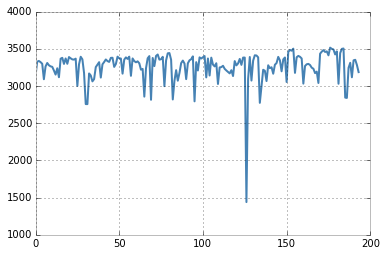

In [5]:
#Taking the mean for each week 
meana = []
for i in range(194):
    meana.append(np.mean(mta[:,:,i]))

#Setting threshold and applying in new plot
thresholds = [np.mean(meana) + 3*np.std(meana), 
              np.mean(meana) - 3*np.std(meana)]
print thresholds

#Finding the week of occurence of the event
for i in range(194):
    if meana[i]<(thresholds[1]) :
        print 'Event happens on week', i 

#Plotting time series
plt.plot(range(194),meana)

    The time series plot of overall average per week

####Method 2

Replacing negative values with NaN and using numpy NaN functions.

Events that cross the threshold (array([127, 128, 129, 130], dtype=int64),)


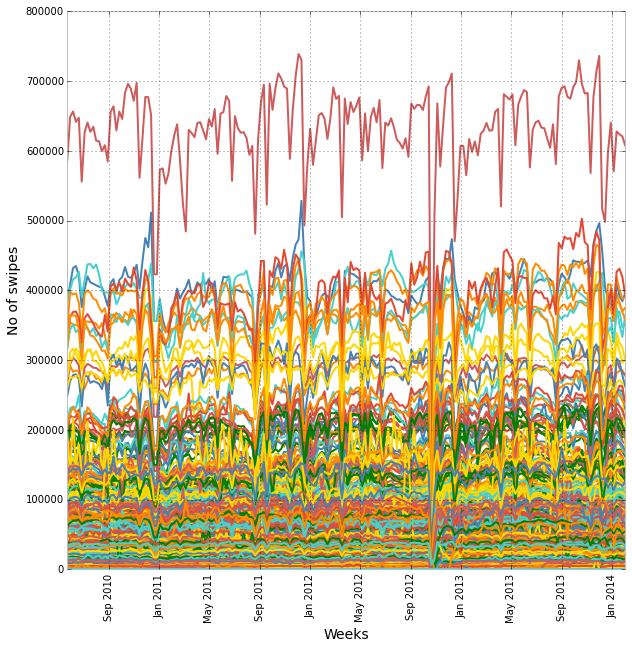

In [6]:
mta = np.load('MTA_Fare.npy')
#Replacing the negative values with NaN
mta = where(mta<0, 'NaN', mta)
mta.shape

#Converting to float to perform arithmetic operations
mta = mta.astype(float)

#Summing on ridetypes so we have only stations and weeks
mta_stations = np.nansum(mta, axis=1)
mta_stations.shape

plt.figure(figsize=(10, 10), dpi=200)
ax = pl.plot(mta_dates, np.transpose(mta_stations))
#we used transpose to get the time on the x axis
pl.ylabel('No of swipes', fontsize = 14)
pl.xlabel('Weeks', fontsize = 14)
pl.xticks(rotation = 90)

#Calculating threshold to detect events
thresholds = [np.nanmean(mta_stations, axis=1) + 3*np.nanstd(mta_stations, axis=1), 
              np.nanmean(mta_stations, axis=1) - 3*np.nanstd(mta_stations, axis=1)]

#Checking for events
event = [np.where(ts < thresholds[1][i]) for i,ts in enumerate(mta_stations)]
print 'Events that cross the threshold', event[0]

                   The time series plot of all stations versus each week

###Analysis: 

The event is Hurricane Sandy which hit on October 22nd 2012 (126 weeks from May 21st 2010)

###Task 2

Aim: To find non-stationary ridership types (increasing and decreasing) and the factor of change. 

Concept: Stationarity of a time series. A time series is stationary if its mean and standard deviation over different intervals remain relatively the same.

(23L, 194L)


(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

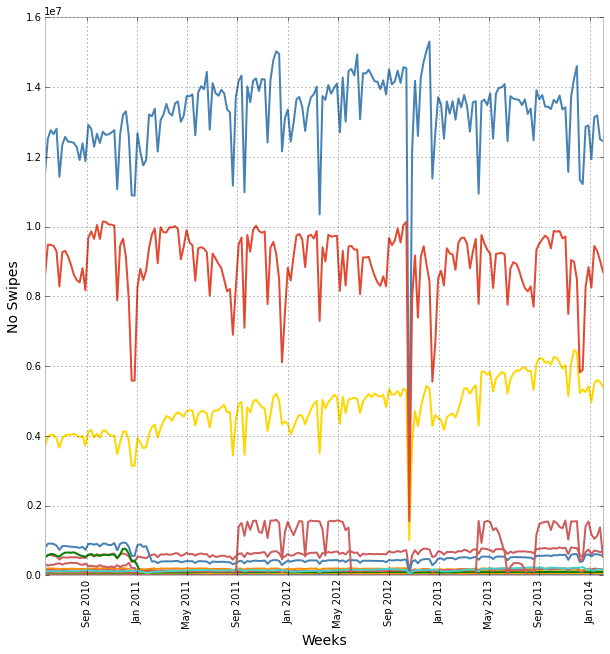

In [7]:
#Summing on stations so we have ridertypes and weeks
mta_types = np.nansum(mta, axis=0)
print mta_types.shape

#Plotting
plt.figure(figsize=(10, 10), dpi=200)
ax = pl.plot(mta_dates, np.transpose(mta_types))
pl.ylabel('No Swipes', fontsize = 14)
pl.xlabel('Weeks', fontsize = 14)
pl.xticks(rotation = 90)

               Time series plot of ridertypes versus each week

(194L, 23L)


(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

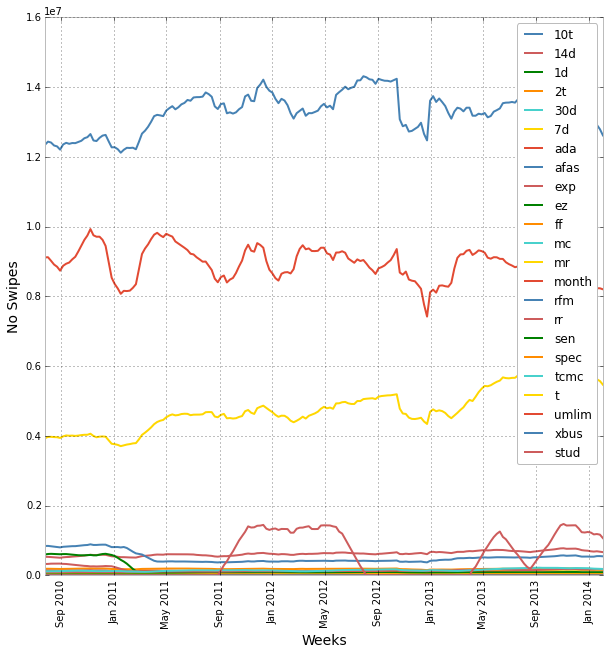

In [8]:
#Performing rolling mean
plt.figure(figsize=(10, 10), dpi=200)
smooth_types = pd.rolling_mean(np.transpose(mta_types), 10)
print smooth_types.shape

#Plotting
ax = pl.plot(mta_dates, smooth_types)
pl.ylabel('No Swipes', fontsize = 14)
pl.xlabel('Weeks', fontsize = 14)
pl.legend(ridetype)
pl.xticks(rotation = 90)

                     Plots of rolled mean ridertypes

[  9.85855761e-01   7.96898334e-01   9.01896857e-01   1.07217516e+00
   9.83155326e-01   7.26253084e-01   1.11214933e+00   4.80765217e+03
   9.42633429e+04   6.82381556e+05   1.23714609e+00   8.30622261e-01
   3.89558171e-05   1.74222625e+00   1.54426917e+00   3.87513943e-01
   3.47208425e-01   5.46373828e-02   6.53059649e-01   9.80984190e-01
   1.26020779e+00   6.18746842e-01   0.00000000e+00]


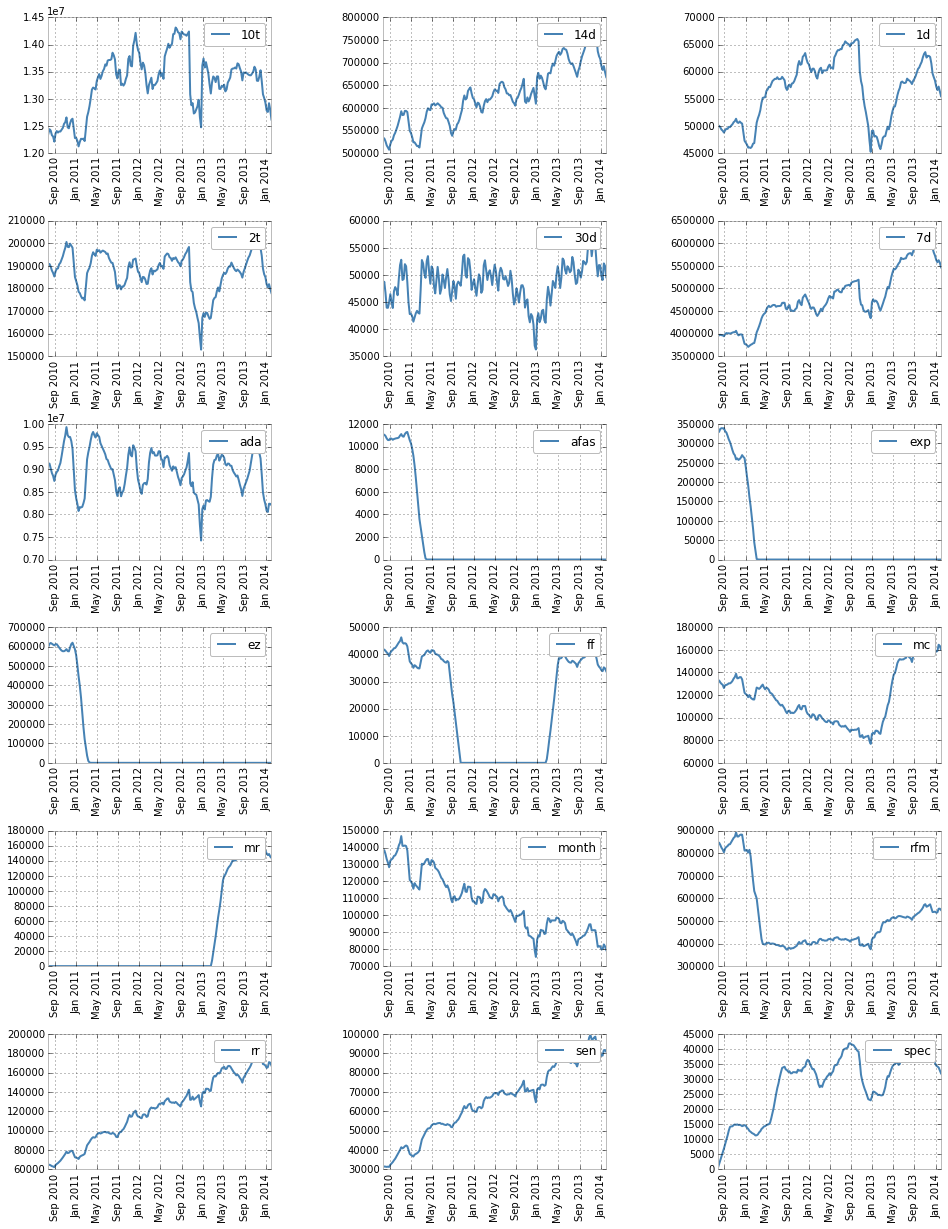

In [9]:
#Calculating ratio of beginning to end for ridertypes
rollingratio = smooth_types[10,:]/smooth_types[193,:]
#Eliminating tpes that show almost no change
#which will be ratios very close to 1
#and plotting all the ones that do.
plt.figure(figsize=(16, 16), dpi=200)
n = 1; j = 0
for i in rollingratio:
    if i>0.9 and i<1.1:
        continue
        j += 1
    else:
        pl.subplot(6, 3, n)
        ax = pl.plot(mta_dates, smooth_types[:, j])
        pl.legend(ridetype[j:])
        pl.xticks(rotation = 90)
        n += 1; j += 1
print rollingratio
#Making the plots look neat
pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=0)

                       Plots of ridertypes (rolled means) that show a change in ratio of beginning to end 

In [10]:
#We can make out increasing and decreasing trends from the plots
#and will print out the reidertypes that show trend

trends = [1, 5, 13, 15, 16, 17, 18, 21]

for n in trends:
    if n != 13:
        print '%s passes are increasing at an approximate rate of %f.' % (ridetype[n], rollingratio[n])
    else:
        print '%s passes are decreasing at an approximate rate of %f.' % (ridetype[n], rollingratio[n])

14d passes are increasing at an approximate rate of 0.796898.
7d passes are increasing at an approximate rate of 0.726253.
month passes are decreasing at an approximate rate of 1.742226.
rr passes are increasing at an approximate rate of 0.387514.
sen passes are increasing at an approximate rate of 0.347208.
spec passes are increasing at an approximate rate of 0.054637.
tcmc passes are increasing at an approximate rate of 0.653060.
xbus passes are increasing at an approximate rate of 0.618747.


###Task 3

Aim: To find the stations that show the most periodic trend annually.

Concept: Fourier series to put the data into periodic series. Analysis of Power Spectrum.

In [11]:
f

<function f>

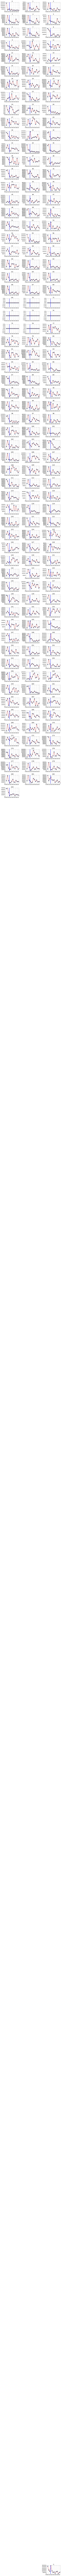

In [22]:
#Applying fourier transform on stations data
f = np.abs(np.fft.rfft(mta_stations))
f.shape

#Taking absolute real values of the fourier transform
ffreq = np.fft.rfftfreq(194, d=1.0)
ffreq.shape

fig = plt.figure(figsize=(10,400))
mtastats = pd.DataFrame(mta_stations)

#making 600 plots in for loop
for i in range(600):
    ax = fig.add_subplot(200,3,i)
    f = np.abs(np.fft.rfft(mtastats.loc[i,:]))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms = 8)
    ax.set_title("%i" %(i-1))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
    ax.set_xlim(0,1.0/15)
    plt.axvline(1.0/52)
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)
    if np.abs(np.fft.rfft(mta_stations))[i][3] >= max(np.abs(np.fft.rfft(mta_stations))[i])*0.95:
        print i
        

              Fourier plots ofeach station to check for periodicity

In [21]:
np.abs(np.fft.rfft(mta_stations))[1][3] == max(np.abs(np.fft.rfft(mta_stations))[1])

False

In [18]:
print np.fft.rfftfreq(194, 1.0)[1:]
print 1/52.0

[ 0.00515464  0.01030928  0.01546392  0.02061856  0.0257732   0.03092784
  0.03608247  0.04123711  0.04639175  0.05154639  0.05670103  0.06185567
  0.06701031  0.07216495  0.07731959  0.08247423  0.08762887  0.09278351
  0.09793814  0.10309278  0.10824742  0.11340206  0.1185567   0.12371134
  0.12886598  0.13402062  0.13917526  0.1443299   0.14948454  0.15463918
  0.15979381  0.16494845  0.17010309  0.17525773  0.18041237  0.18556701
  0.19072165  0.19587629  0.20103093  0.20618557  0.21134021  0.21649485
  0.22164948  0.22680412  0.23195876  0.2371134   0.24226804  0.24742268
  0.25257732  0.25773196  0.2628866   0.26804124  0.27319588  0.27835052
  0.28350515  0.28865979  0.29381443  0.29896907  0.30412371  0.30927835
  0.31443299  0.31958763  0.32474227  0.32989691  0.33505155  0.34020619
  0.34536082  0.35051546  0.3556701   0.36082474  0.36597938  0.37113402
  0.37628866  0.3814433   0.38659794  0.39175258  0.39690722  0.40206186
  0.40721649  0.41237113  0.41752577  0.42268041  0